<a href="https://colab.research.google.com/github/gsilver321/project_voting/blob/main/project3_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 Voting Paper
### DS 3001: Foundations of Machine Learning
### Gabe Silverstein, Rohan Chowla, Evan Stewart, and Rithwik Raman

## Summary

>  A one paragraph description of the question, methods, and results (about 350 words).





## Data Analysis



> Data: One to two pages discussing the data and key variables, and any challenges in reading, cleaning, and preparing them for analysis.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.axes_grid1 import make_axes_locatable
from zipfile import ZipFile
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, TwoSlopeNorm

! git clone https://github.com/gsilver321/project_voting

Cloning into 'project_voting'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 184 (delta 43), reused 28 (delta 28), pack-reused 125
Receiving objects: 100% (184/184), 124.67 MiB | 12.17 MiB/s, done.
Resolving deltas: 100% (88/88), done.
Updating files: 100% (65/65), done.


In [2]:
# Extract large shp files
with ZipFile('project_voting/va_bounds/VirginiaCounty_ClippedToShoreline.zip') as f:
  f.extractall(path='project_voting/va_bounds')

with ZipFile('project_voting/va_bounds/VirginiaTown_ClippedToShoreline.zip') as f:
  f.extractall(path='project_voting/va_bounds')

In [3]:
# Load data
gdf = gpd.read_file('project_voting/va_bounds/VirginiaCounty_ClippedToShoreline.shx') # Load Virginia shapefile for maps
cdf = pd.read_csv('project_voting/data/county_adjacencies.csv') # Load county adjacency data and population data

ddf = pd.read_csv('project_voting/data/demographic_info.csv') # data cleaning can be found at voting_cleaning.ipynb in GitHub
df_train = pd.read_csv('project_voting/data/df_train.csv')
df_test = pd.read_csv('project_voting/data/df_test.csv')

# Merge shapefile data and county adjacency data:
gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS'])
df = gdf.merge(cdf, left_on='FIPS_left', right_on='FIPS')  # merge county population and adjacency data into df
del gdf, cdf

In [4]:
# scale data before feature selection
scaler = MinMaxScaler(feature_range=(0,1))
ddf_scale = ddf.drop("COUNTY", axis=1)
ddf_scale = pd.DataFrame(scaler.fit_transform(ddf_scale), columns=ddf_scale.columns)

df_test_scale = df_test.drop("COUNTY", axis=1)
df_test_scale = pd.DataFrame(scaler.fit_transform(df_test_scale), columns=df_test_scale.columns)

In [5]:
cor_df = ddf_scale.copy()
cor_df['Vote Diff'] = np.arcsinh(df_train['vote_diff'])
cor_df.corr(method='kendall') # look for any relationships between variables. Use kendall coefficient to check for nonlinear relationship

,College Degree,Labor Force,Foreigners,Females,Income,Poverty,Rural,Black or African American,Latinx,AAPI,Never Married,65+,Prob Dem,Vote Diff
College Degree,1.000000,0.829346,0.756209,0.801777,0.429532,0.562315,0.197306,0.455281,0.724476,0.742024,0.708817,0.662110,0.068529,0.079973
Labor Force,0.829346,1.000000,0.714514,0.936432,0.311724,0.667350,0.270476,0.493563,0.719690,0.707840,0.802005,0.742538,0.040755,0.017316
Foreigners,0.756209,0.714514,1.000000,0.688312,0.355247,0.529050,0.083409,0.500855,0.858478,0.875570,0.675097,0.566416,0.048000,0.208020
Females,0.801777,0.936432,0.688312,1.000000,0.268657,0.713602,0.295326,0.491512,0.691203,0.680036,0.828207,0.788790,0.044378,-0.002051
Income,0.429532,0.311724,0.355247,0.268657,1.000000,0.034864,0.050512,0.159754,0.335499,0.353960,0.168395,0.181839,0.048006,0.126467
Poverty,0.562315,0.667350,0.529050,0.713602,0.034864,1.000000,0.226758,0.471232,0.539426,0.530310,0.766006,0.738437,0.002717,0.037822
Rural,0.197306,0.270476,0.083409,0.295326,0.050512,0.226758,1.000000,0.025658,0.082738,0.053509,0.216404,0.321327,0.029420,-0.445348
Black or African American,0.455281,0.493563,0.500855,0.491512,0.159754,0.471232,0.025658,1.000000,0.527863,0.526952,0.547112,0.447078,-0.043477,0.293722
Latinx,0.724476,0.719690,0.858478,0.691203,0.335499,0.539426,0.082738,0.527863,1.000000,0.907910,0.670237,0.558569,0.044086,0.200547
AAPI,0.742024,0.707840,0.875570,0.680036,0.353960,0.530310,0.053509,0.526952,0.907910,1.000000,0.672972,0.544895,0.049521,0.225843


In [6]:
ddf_scale["county_encode"] = range(1, 134)
df_test_scale["county_encode"] = range(1, 134)

## Results

> Two to five pages providing visualizations, statistics, tables, a discussion of your methodology, and a presentation of your main results. In particular, how are you approaching the prediction problem? How confident are you about your assessments that counties will support one party or the other?


<Axes: xlabel='vote_diff', ylabel='Count'>

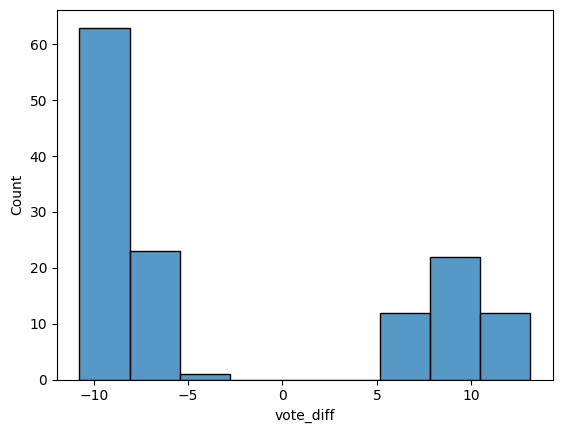

In [22]:
sns.histplot(np.arcsinh(df_train['vote_diff']))

In [23]:
forest_params = [{'max_depth': range(1, 11), 'max_features': range(5, 14)}]

clf = GridSearchCV(RandomForestRegressor(), forest_params, cv=5, scoring='neg_root_mean_squared_error')
clf.fit(ddf_scale, df_train["vote_diff"])
clf.best_params_

{'max_depth': 1, 'max_features': 13}

In [20]:
# Fit random forest:
rf = RandomForestRegressor(max_depth=10, max_features=12)
rf = rf.fit(ddf_scale, df_train["vote_diff"])

# Make predictions:
pred = rf.predict(ddf_scale)
pred_scale = np.arcsinh(pred) # rescale votes

df["Vote Differential"] = pred_scale
df

,STCOFIPS,GNIS,NAME,NAMELSAD,GSOURCE,LADOPT,LASTUPDATE,JURISTYPE,AREASQMI,Shape_Leng,...,N4,N5,N6,N7,N8,N9,N10,N11,N12,Vote Differential
0,51001,1480091,Accomack,Accomack County,T,N,2014-08-20,CO,1195.366291,4.949957e+06,...,Mathews,Northampton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.643076
1,51003,1675170,Albemarle,Albemarle County,L,Y,2021-03-29,CO,725.634334,2.310198e+05,...,Rockingham,Greene,Orange,Louisa,Fluvanna,Buckingham,Nelson,NaN,NaN,10.015569
2,51005,1492459,Alleghany,Alleghany County,V,N,2014-09-15,CO,449.544769,2.062654e+05,...,CovingtonCity,Rockbridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.646026
3,51007,1497770,Amelia,Amelia County,T,Y,2021-03-29,CO,360.945234,1.776617e+05,...,Chesterfield,Dinwiddie,Nottoway,NaN,NaN,NaN,NaN,NaN,NaN,-8.712224
4,51009,1480095,Amherst,Amherst County,V,N,2020-09-11,CO,478.766949,1.876610e+05,...,Campbell,Bedford,LynchburgCity,NaN,NaN,NaN,NaN,NaN,NaN,-8.519134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,51800,1498560,Suffolk,Suffolk City,L,Y,2017-06-23,CI,428.933821,6.716418e+05,...,NewportNewsCity,HamptonCity,PortsmouthCity,NaN,NaN,NaN,NaN,NaN,NaN,8.043857
129,51810,1498559,Virginia Beach,Virginia Beach City,L,Y,2017-01-25,CI,408.144012,1.350634e+06,...,HamptonCity,ChesapeakeCity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.912777
130,51820,1498443,Waynesboro,Waynesboro City,L,Y,2014-06-16,CI,15.110987,3.244646e+04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.808244
131,51830,1789076,Williamsburg,Williamsburg City,L,Y,2017-01-25,CI,9.032769,4.150800e+04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.725202


In [10]:
print(np.min(df['Vote Differential']), np.max(df['Vote Differential']))

-19635.145454545454 172185.8454285714


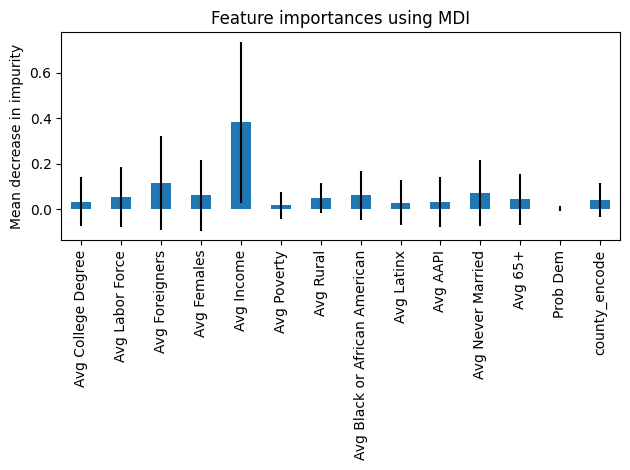

In [24]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=df_test_scale.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

<ipython-input-26-e66caab0d036>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('Blues', 128);
<ipython-input-26-e66caab0d036>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap('Reds_r', 128);


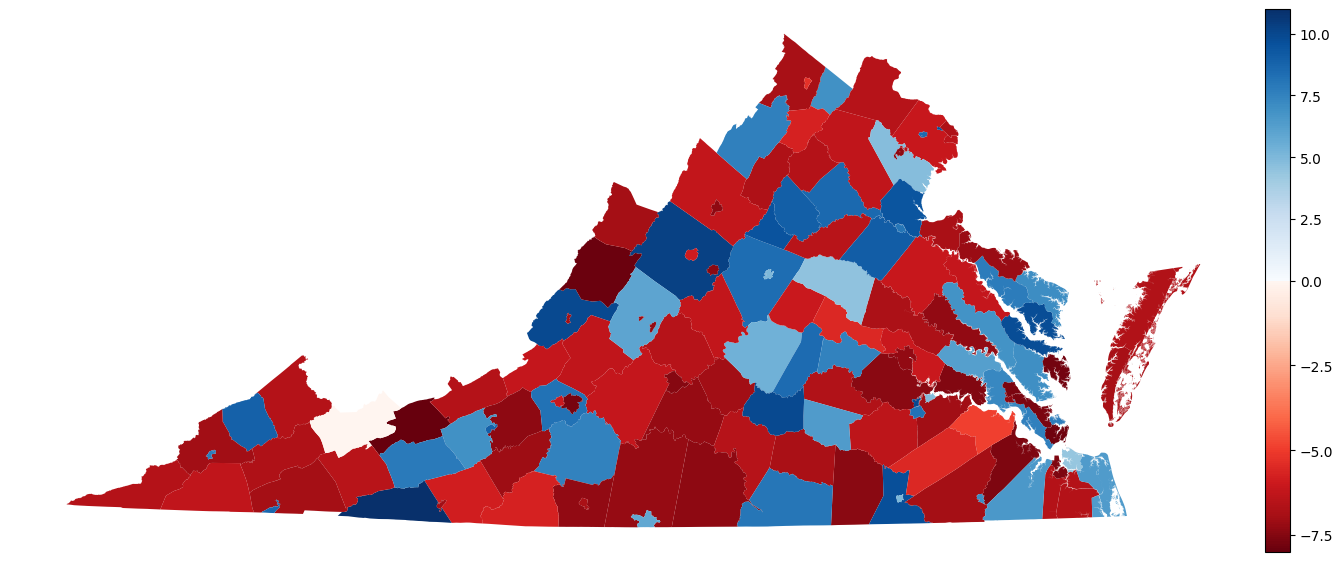

In [26]:
top = cm.get_cmap('Blues', 128)
bottom = cm.get_cmap('Reds_r', 128)
newcolors = np.vstack((bottom(np.linspace(0, 1, 128)), top(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='BlueRed')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax, column='Vote Differential', legend=True, cax=cax, cmap=newcmp)

divnorm = TwoSlopeNorm(vmin=-8, vcenter=0, vmax=11)
sm = cm.ScalarMappable(cmap=newcmp, norm=divnorm)
cb = fig.colorbar(sm, cax=cax)

## Conclusion

> One to two pages summarizing the project, defending it from criticism, and suggesting additional work that was outside the scope of the project.

#### Reference
*All data for this project was derived from IPUMS NHGIS, which is available in our repository and at https://www.nhgis.org/*